Solving Lunar

https://github.com/robintyh1/gym-mac#supported-systems 

In [1]:
#! brew install boost-python
! pip install box2d
! pip install gym
! pip install tqdm

In [2]:
#! pip install git+https://github.com/openai/gym.git#egg=gym[box2d]

In [3]:
import numpy as np
import random
import torch 
import torch.nn as nn
import gym

from tqdm.notebook import trange, tqdm

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
#import gym
from gym import wrappers

env = gym.make('LunarLander-v2')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

In [5]:
import gym

env = gym.make("LunarLander-v2")
env.reset()

for _ in range(1000):
    env.render()
    _, _, is_done, _ = env.step(env.action_space.sample()) #take a random action
    
    if is_done:
        break

env.close()

In [6]:
class ValueFunction(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.V = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.SELU(),
            nn.Linear(128, 256),
            nn.SELU(),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        v = self.V(x)

        return v

In [7]:
class SoftmaxPolicy(nn.Module):
    def __init__(self, input_size, num_actions):
        super().__init__()
        
        self.input_size = input_size
        self.num_actions = num_actions
        
        self.pi = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.SELU(),
            nn.Linear(128, 256),
            nn.SELU(),
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, num_actions),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x):
        logits = self.pi(x)
        
        return logits

In [8]:
cc = 0 

In [9]:
def sample_action(logits):
    return Categorical(logits=logits).sample()


In [10]:
from torch.distributions.categorical import Categorical
import itertools

obs = env.reset()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pi = SoftmaxPolicy(input_size=8, num_actions=4).to(device)
old_pi = SoftmaxPolicy(input_size=8, num_actions=4).to(device)
value_fun = ValueFunction(input_size=8).to(device)

state = torch.from_numpy(obs).float()
logits = pi(state.unsqueeze(0).to(device))
logits.squeeze(0)

sample_action(logits.squeeze(0).cpu())


tensor(3)

In [11]:
γ = 0.99

def collect_experience(env, policy):
    obs = env.reset()
    
    memory = []
    rewards = []
    states = []
    actions = []
    logps = []
    score = []
    policy.eval()
    
    with torch.no_grad():
        for i in itertools.count():
            state = torch.from_numpy(obs).float()
            logits = policy(state.unsqueeze(0).to(device))
            act = sample_action(logits.cpu().squeeze())
            
            obs, reward, is_done, onfi = env.step(act.item())
            
            states.append(state)
            actions.append(act)
            score.append(reward)
            rewards.append(torch.tensor(reward/200.0, dtype=torch.float))
            logps.append(logits[0, act.item()])
            
            if is_done:
                break
                
    values = []
    acc = 0.0
    for r in reversed(rewards):
        acc = γ * acc + r
        values.insert(0, acc)
    
    return zip(states, actions, values, logps), np.sum(score)

In [12]:
import math
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_value_
LEARNING_RATE = 1e-4

params = itertools.chain(pi.parameters(), value_fun.parameters())
optim = torch.optim.Adam(params, lr=LEARNING_RATE)


In [13]:
from collections import deque

eps = 0.2
step = 0
rewards = []
scores_window = deque(maxlen=100)
no_experiences = 30

for loop in trange(800):
    
    rewards.append(0)
    experiences = []
    

    for episode in range(no_experiences):
        exp, reward = collect_experience(env, pi)
        experiences.extend( exp )
        rewards[loop] += reward
    rewards[loop] /= no_experiences

    scores_window.append(rewards)
            
    dataloader = DataLoader(experiences, batch_size=32, shuffle=True)
    
    value_fun.train()
    pi.train()
    
    old_pi.load_state_dict( pi.state_dict())
    old_pi.eval()

    for state, action, value, logp_old in dataloader:
        step += 1
        state_on_device = state.to(device)
        state_value = value_fun(state_on_device)
        value_loss = nn.functional.mse_loss(input=state_value, 
                                     target=value.unsqueeze(1).to(device))
        
        logits = pi(state_on_device)
        logp = logits.gather(dim=1, index=action.unsqueeze(1).to(device))
        
        with torch.no_grad():
            advantage = value.unsqueeze(1).to(device) - state_value
            
        ratio = (logp - logp_old.unsqueeze(1).to(device)).exp()
        entropy = - logits * logits.exp()
        
        pi_loss = - torch.min(ratio * advantage, 
                             torch.clamp(ratio, min=1.0 - eps, max = 1.0 + eps) * advantage) - 1e-4 * entropy
        pi_loss = pi_loss.mean()
        
        loss = pi_loss + value_loss
        
        optim.zero_grad()
        loss.backward()
        
        clip_grad_value_( params, 1.0)
        optim.step()
        
    if loop % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(loop, np.mean(scores_window)))
        
     

Episode 0	Average Score: -181.20
Episode 100	Average Score: 129.19
Episode 200	Average Score: 265.16
Episode 300	Average Score: 262.12
Episode 400	Average Score: 265.59
Episode 500	Average Score: 268.09
Episode 600	Average Score: 267.73
Episode 700	Average Score: 268.33



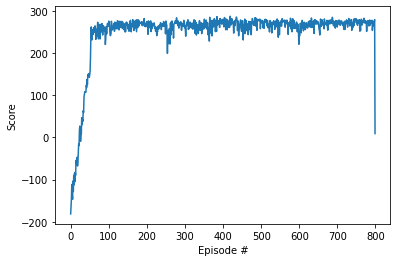

In [19]:

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rewards)), rewards)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:

for _ in range(20):
    
    obs = env.reset()
        
    with torch.no_grad():
        for i in range(1000):
            env.render()
            state = torch.from_numpy(obs).float()
            logits = pi(state.unsqueeze(0).to(device))
            act = sample_action(logits.cpu().squeeze())
            
            obs, _, is_done, _ = env.step(act.item()) #take a random action

            if is_done:
                break

env.close()